In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
# результаты построения корреляционных моделий разные в зависимости от того:
# был ли данные преобразованы использован long-format или нет.

In [3]:
df = pd.read_csv('J:/HiEnd/mlcourse_open-master (2)/mlcourse_open-master/data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [5]:
df = df[df['ap_lo'] <= df['ap_hi']]
filtered_df = df[(df['ap_lo'] <= df['ap_hi']) & 
                 (df['height'] >= df['height'].quantile(0.025)) &
                 (df['height'] <= df['height'].quantile(0.975)) &
                 (df['weight'] >= df['weight'].quantile(0.025)) & 
                 (df['weight'] <= df['weight'].quantile(0.975))]
print(filtered_df.shape[0] / df.shape[0])

0.9179827240205916


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68766 entries, 0 to 99999
Data columns (total 12 columns):
age            68766 non-null int64
gender         68766 non-null int64
height         68766 non-null int64
weight         68766 non-null float64
ap_hi          68766 non-null int64
ap_lo          68766 non-null int64
cholesterol    68766 non-null int64
gluc           68766 non-null int64
smoke          68766 non-null int64
alco           68766 non-null int64
active         68766 non-null int64
cardio         68766 non-null int64
dtypes: float64(1), int64(11)
memory usage: 6.8 MB


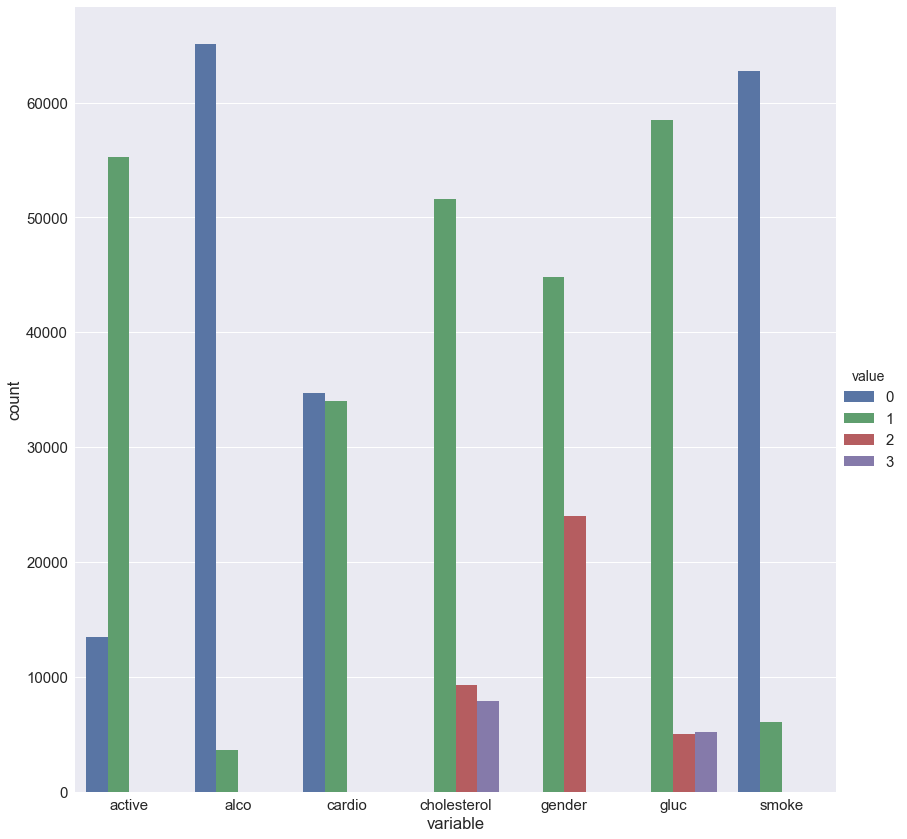

In [7]:
# преобразование данных в long-format 

df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                                    'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               data=df_uniques, kind='bar', size=12);

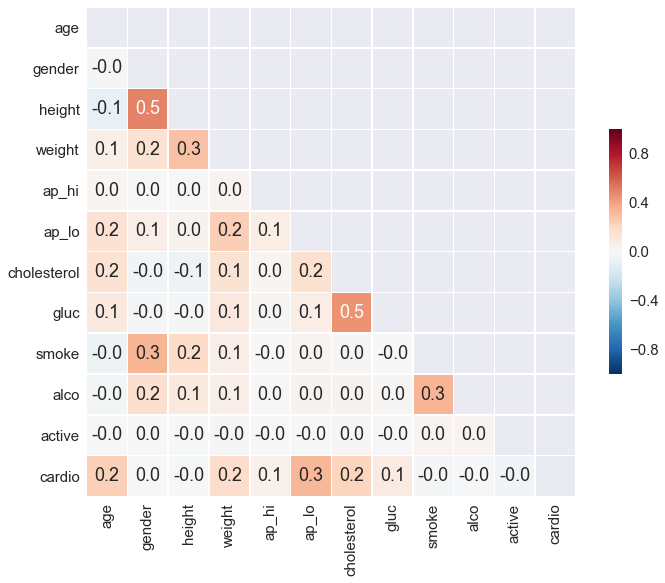

In [8]:
corr = df.corr(method='pearson')

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});   

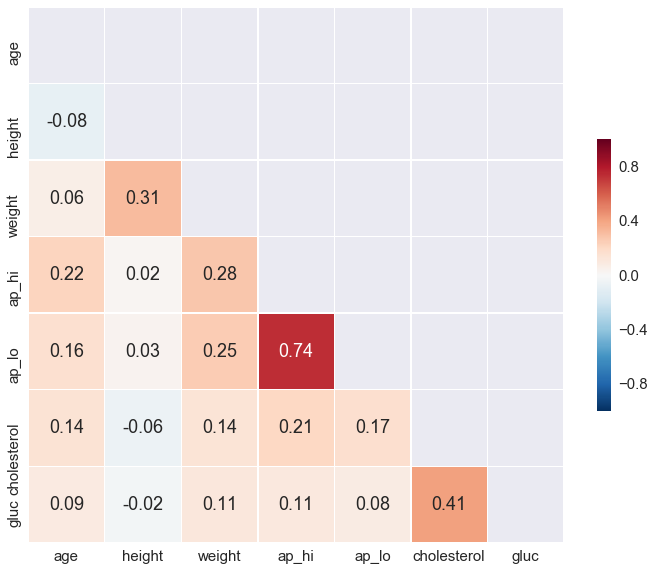

In [9]:
# график корреляция по Спирману
corr = df[['age', 'height', 'weight', 
              'ap_hi', 'ap_lo', 'cholesterol', 
              'gluc']].corr(method='spearman')

# Маска для закрытия верхнего треугольника матрицы корреляций (матрица симметрична)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [10]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

age
8065
----------
gender
2 [(1, 44793), (2, 23973)]
----------
height
106
----------
weight
281
----------
ap_hi
138
----------
ap_lo
93
----------
cholesterol
3 [(1, 51570), (2, 9316), (3, 7880)]
----------
gluc
3 [(1, 58475), (2, 5070), (3, 5221)]
----------
smoke
2 [(0, 62723), (1, 6043)]
----------
alco
2 [(0, 65098), (1, 3668)]
----------
active
2 [(0, 13516), (1, 55250)]
----------
cardio
2 [(0, 34743), (1, 34023)]
----------


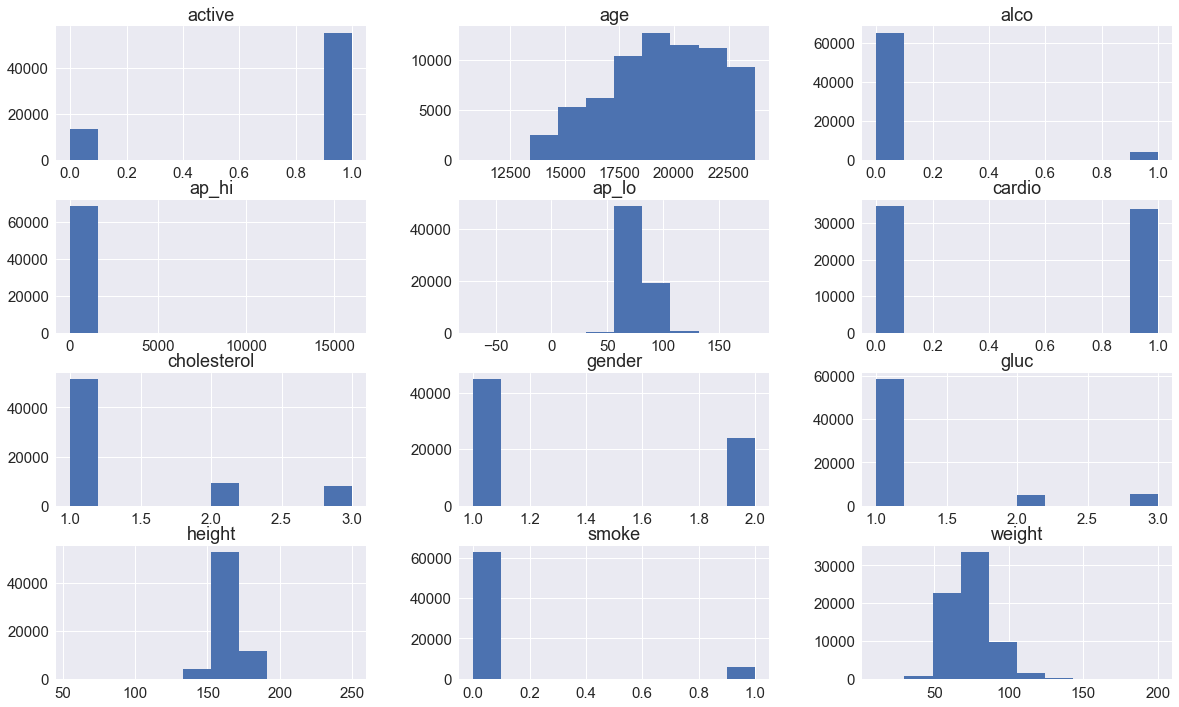

In [11]:
features = df.columns
df[features].hist(figsize=(20,12));

In [12]:
df.corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.023153,-0.081017,0.054940,0.020340,0.153535,0.155220,0.098943,-0.047514,-0.028606,-0.010163,0.239223
gender,-0.023153,1.000000,0.498332,0.155851,0.005878,0.065758,-0.036902,-0.021188,0.338701,0.171149,0.005983,0.007141
height,-0.081017,0.498332,1.000000,0.291379,0.005662,0.036527,-0.050662,-0.018558,0.188095,0.094471,-0.007387,-0.010406
weight,0.054940,0.155851,0.291379,1.000000,0.029656,0.249128,0.140945,0.106989,0.067038,0.067354,-0.017851,0.179704
ap_hi,0.020340,0.005878,0.005662,0.029656,1.000000,0.076080,0.022842,0.011637,-0.001340,0.001465,-0.000484,0.053189
ap_lo,0.153535,0.065758,0.036527,0.249128,0.076080,1.000000,0.157580,0.074568,0.025633,0.036893,-0.001771,0.332474
cholesterol,0.155220,-0.036902,-0.050662,0.140945,0.022842,0.157580,1.000000,0.450375,0.009865,0.035027,0.008770,0.221474
gluc,0.098943,-0.021188,-0.018558,0.106989,0.011637,0.074568,0.450375,1.000000,-0.005857,0.010259,-0.007884,0.089695
smoke,-0.047514,0.338701,0.188095,0.067038,-0.001340,0.025633,0.009865,-0.005857,1.000000,0.340505,0.025302,-0.016321
alco,-0.028606,0.171149,0.094471,0.067354,0.001465,0.036893,0.035027,0.010259,0.340505,1.000000,0.024582,-0.008646


In [13]:
df.corr(method='spearman')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.020479,-0.081720,0.062685,0.222292,0.158324,0.140812,0.092127,-0.047343,-0.028957,-0.010542,0.235701
gender,-0.020479,1.000000,0.532858,0.172545,0.063255,0.064991,-0.036911,-0.019696,0.338701,0.171149,0.005983,0.007141
height,-0.081720,0.532858,1.000000,0.314028,0.021571,0.032252,-0.059537,-0.024237,0.197542,0.096758,-0.007626,-0.012058
weight,0.062685,0.172545,0.314028,1.000000,0.277888,0.252399,0.136500,0.109512,0.071326,0.067890,-0.015622,0.180601
ap_hi,0.222292,0.063255,0.021571,0.277888,1.000000,0.740659,0.208331,0.106559,0.028177,0.034832,-0.003440,0.451380
ap_lo,0.158324,0.064991,0.032252,0.252399,0.740659,1.000000,0.165931,0.081976,0.024910,0.036378,0.001619,0.356303
cholesterol,0.140812,-0.036911,-0.059537,0.136500,0.208331,0.165931,1.000000,0.406464,0.014856,0.040446,0.006373,0.215100
gluc,0.092127,-0.019696,-0.024237,0.109512,0.106559,0.081976,0.406464,1.000000,-0.000549,0.017445,-0.009905,0.091880
smoke,-0.047343,0.338701,0.197542,0.071326,0.028177,0.024910,0.014856,-0.000549,1.000000,0.340505,0.025302,-0.016321
alco,-0.028957,0.171149,0.096758,0.067890,0.034832,0.036378,0.040446,0.017445,0.340505,1.000000,0.024582,-0.008646


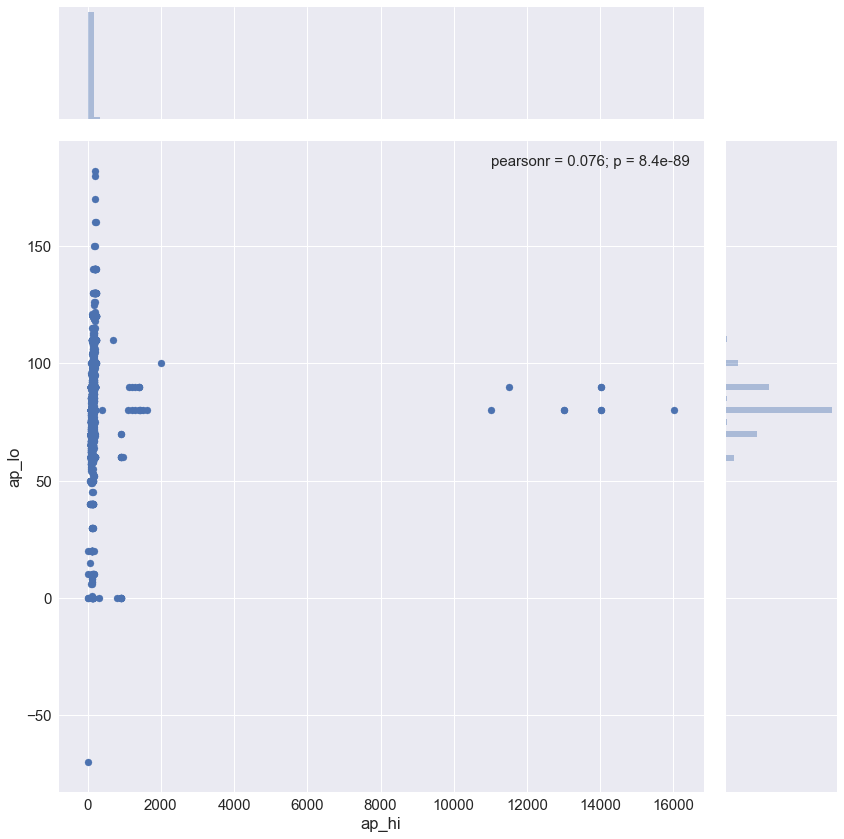

In [14]:
# два наиболее коррелирующий признака по спирману.
sns.jointplot(df['ap_hi'], df['ap_lo'], size=12, marginal_kws=dict(bins=100, rug=False));

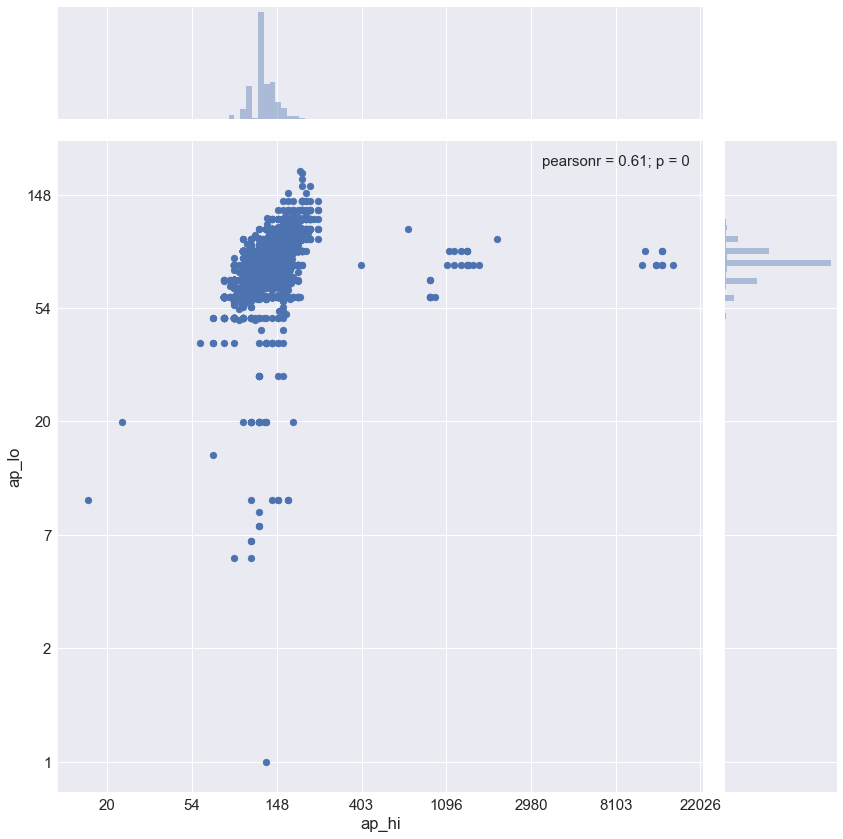

In [15]:
# графики получиль неинформативным из-за выбросов в значениях. Построем те же графики но с логарифмической шкалой

tmp_df = df[(df['ap_hi'] > 0) & (df['ap_lo'] > 0)][['ap_lo', 'ap_hi']].apply(np.log)
g = sns.jointplot(tmp_df['ap_hi'], tmp_df['ap_lo'], size= 12, marginal_kws=dict(bins=100, rug=False))
# -------------------- #

"""Сетка"""
g.ax_joint.grid(True) 

"""Преобразуем логарифмические значения на шкалах в реальные"""
g.ax_joint.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(round(int(np.exp(x))))))
g.ax_joint.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(round(int(np.exp(x))))))